# This notebook is meant to draw all the plots regarding ddPCM paper

___

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import re

fmm_dir = "../experiments/previous_runs_vdw/fmm_vs_fmm_vdw"
large_dir = "../experiments/previous_runs_vdw/large_fmm_vdw"
dense_dir = "../experiments/previous_runs_vdw/dense_vs_fmm_vdw"

font = {'size': 10,
       'family': 'serif',
       'serif': ['Computer Modern']}
mpl.rc('font', **font)
mpl.rc('text', usetex=True)

In [2]:
# A function that reads .fmm and .dense output files
def read_output_file(fname):
    # Init output dict
    result = {}
    # Read entire file in a single shot
    with open(fname, "r") as fd:
        lines = fd.readlines()
    # Number of atoms
    natoms = int(lines[18].split()[0])
    result["natoms"] = natoms
    #print(natoms)
    # Find start of output
    iline = 0
    while(lines[iline] != "=====OUTPUT=====\n"):
        #print(iline, lines[iline])
        iline += 1
    # Read time of mkrhs
    iline += 2
    result["mkrhs time"] = float(lines[iline].split()[2])
    # Cycle through iterations of the ddPCM system
    iline += 1
    while(lines[iline][:5] != "ddpcm"):
        #print(iline, lines[iline])
        iline += 1
    result["ddpcm step time"] = float(lines[iline].split()[3])
    iline += 1
    result["ddpcm step niter"] = int(lines[iline].split()[3])
    # Cycle through iterations of the ddCOSMO system
    iline += 1
    while(lines[iline][:7] != "ddcosmo"):
        #print(iline, lines[iline])
        iline += 1
    result["ddcosmo step time"] = float(lines[iline].split()[3])
    iline += 1
    result["ddcosmo step niter"] = int(lines[iline].split()[3])
    # Cycle through iterations of the adjoint ddCOSMO system
    iline += 1
    while(lines[iline][:7] != "adjoint"):
        #print(iline, lines[iline])
        iline += 1
    result["adjoint ddcosmo step time"] = float(lines[iline].split()[4])
    iline += 1
    result["adjoint ddcosmo step niter"] = int(lines[iline].split()[4])
    # Cycle through iterations of the adjoint ddPCM system
    iline += 1
    while(lines[iline][:7] != "adjoint"):
        #print(iline, lines[iline])
        iline += 1
    result["adjoint ddpcm step time"] = float(lines[iline].split()[4])
    iline += 1
    result["adjoint ddpcm step niter"] = int(lines[iline].split()[4])
    # Total ddPCM time
    iline += 1
    result["ddpcm time"] = float(lines[iline].split()[2])
    iline += 1
    result["ddpcm esolv"] = float(lines[iline].split()[2])
    # Forces
    iline += 2
    forces = np.zeros((natoms, 3))
    for i in range(natoms):
        forces[i] = list(map(float, lines[iline].split()[1:]))
        iline += 1
    result["ddpcm forces"] = forces
    return result

___

## 1. Comparison of a dense ddPCM solver against FMM ddPCM solver
 
- Maximal degree of modeling spherical harmonics:
    - lmax=6,8,10,12
- Maximal degree of the FMM spherical harmonics:
    - pm=pl=pmax=20
- Number of Lebedev grid points:
    - ngrid=590

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


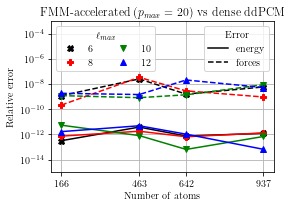

In [3]:
#font = {'size'   : 10,
#       'family': 'serif',
#       'serif': ['Computer Modern']}
#mpl.rc('font', **font)
#mpl.rc('text', usetex=True)

# Plot dense vs fmm accuracy for lmax=6, 8, 10 and 12
lmaxs = [6, 8, 10, 12]
# List output molecules in a proper order (increasing number of atoms)
molecules = ["2rvd_vdw", "2mlt_monomer_vdw", "1ejg_vdw", "2mlt_vdw"]
natoms = [166, 463, 642, 937]
styles = {6: {"color": "black", "marker": "X"},
          8: {"color": "red", "marker": "P"},
          10: {"color": "green", "marker": "v"},
          12: {"color": "blue", "marker": "^"}}

# Create a figure
fig, ax = plt.subplots(figsize=(4, 3))
legend1_handles = []
# Add plots to the figure
for lmax in lmaxs:
    rel_err_esolv = []
    rel_err_forces = []
    for mol in molecules:
        fname_fmm = fmm_dir + "/{}.{}.20.fmm".format(mol, lmax)
        #fname_fmm = dense_dir + "/{}.{}.fmm".format(mol, lmax)
        #print("Read:", fname_fmm)
        result_fmm = read_output_file(fname_fmm)
        fname_dense = dense_dir + "/{}.{}.dense".format(mol, lmax)
        #print("Read:", fname_dense)
        result_dense = read_output_file(fname_dense)
        rel_err_esolv.append(abs((result_fmm["ddpcm esolv"]-result_dense["ddpcm esolv"]) /
                            result_dense["ddpcm esolv"]))
        rel_err_forces.append(np.linalg.norm(result_fmm["ddpcm forces"]-result_dense["ddpcm forces"]) /
                            np.linalg.norm(result_dense["ddpcm forces"]))
    #print(rel_err_esolv)
    #print(rel_err_forces)
    ax.semilogy(natoms, rel_err_esolv, label="{}".format(lmax),
                linestyle="-", **styles[lmax])
    ax.semilogy(natoms, rel_err_forces, label="{}".format(lmax),
                linestyle="dashed", **styles[lmax])
    legend1_handles.append(Line2D([], [], label="{}".format(lmax), linestyle="", **styles[lmax]))
ax.grid()
ax.set_xticks(natoms)
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
ax.set_ylim([1e-15, 1e-3])
ax.set_yticks([1e-4, 1e-6, 1e-8, 1e-10, 1e-12, 1e-14])
ax.set_title("FMM-accelerated ($p_{{max}}=20$) vs dense ddPCM")
ax.set_xlabel("Number of atoms")
ax.set_ylabel("Relative error")
#ax.legend(loc="upper left", ncol=2, fontsize=15).set_title("$\ell_{{max}}$", prop={"size": 15})
legend1 = plt.legend(handles=legend1_handles, loc="upper left", ncol=2)
legend1.set_title("$\ell_{{max}}$")
legend2_handles = [Line2D([], [], linestyle="-", color="black", label="energy"),
                  Line2D([], [], linestyle="dashed", color="black", label="forces")]
legend2 = plt.legend(handles=legend2_handles, loc="upper right", ncol=1)
legend2.set_title("Error")
ax.add_artist(legend1)
fig.tight_layout()
#plt.savefig("dense_vs_fmm_vdw_error.pdf", bbox_inches='tight')
plt.savefig("dense_vs_fmm_vdw_error.pgf")#, bbox_inches='tight')
plt.show()
plt.close()

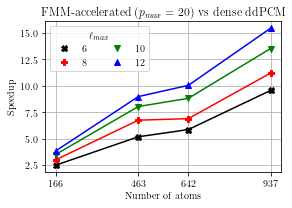

In [53]:
# Plot dense vs fmm time for lmax=6, 8, 10 and 12
lmaxs = [6, 8, 10, 12]
# List output molecules in a proper order (increasing number of atoms)
molecules = ["2rvd_vdw", "2mlt_monomer_vdw", "1ejg_vdw", "2mlt_vdw"]
natoms = [166, 463, 642, 937]
styles = {6: {"color": "black", "marker": "X"},
          8: {"color": "red", "marker": "P"},
          10: {"color": "green", "marker": "v"},
          12: {"color": "blue", "marker": "^"}}
# Create a figure
fig, ax = plt.subplots(figsize=(4, 3))
legend1_handles = []
# Add plots to the figure
for lmax in lmaxs:
    speedup = []
    for mol in molecules:
        fname_fmm = fmm_dir + "/{}.{}.20.fmm".format(mol, lmax)
        #print("Read:", fname_fmm)
        result_fmm = read_output_file(fname_fmm)
        fname_dense = dense_dir + "/{}.{}.dense".format(mol, lmax)
        #print("Read:", fname_dense)
        result_dense = read_output_file(fname_dense)
        speedup.append(result_dense["ddpcm time"] / result_fmm["ddpcm time"])
    ax.plot(natoms, speedup, linestyle="-", **styles[lmax])
    legend1_handles.append(Line2D([], [], label="{}".format(lmax), linestyle="", **styles[lmax]))
ax.grid()
ax.set_xticks(natoms)
#ax.set_ylim([1e-16, 1e-8])
ax.set_title("FMM-accelerated ($p_{{max}}=20$) vs dense ddPCM")
ax.set_xlabel("Number of atoms")
ax.set_ylabel("Speedup")
#ax.legend(loc="upper left", ncol=2)
legend1 = plt.legend(handles=legend1_handles, loc="upper left", ncol=2)
legend1.set_title("$\ell_{{max}}$")
fig.tight_layout()
#plt.savefig("dense_vs_fmm_vdw_speedup.pdf")
plt.savefig("dense_vs_fmm_vdw_speedup.pgf")#, bbox_inches='tight')
plt.show()
plt.close()

___

## 2. Comparison of accuracies of pmax=6, 8, 10 and 12 for different lmax

In [75]:
pmaxs = [6, 8, 10, 12]
lmaxs = [6, 8, 10, 12]

molecules = ["2rvd_vdw", "2mlt_monomer_vdw", "1ejg_vdw", "2mlt_vdw", "2qho_a_vdw",
             "2qho_ab_vdw", "2qho_abc_vdw", "2qho_abcd_vdw", "2qho_vdw",
             "3gdp_vdw", "2gx2_vdw"]
natoms = np.array([166, 463, 642, 937, 1922, 3932, 5941, 7887, 8799, 20479, 46949])

forces_results = np.zeros((len(lmaxs), len(pmaxs), len(molecules)))
energies_results = np.zeros((len(lmaxs), len(pmaxs), len(molecules)))

for i, lmax in enumerate(lmaxs):
    for j, pmax in enumerate(pmaxs):
        for k, mol in enumerate(molecules):
            fname_fmm = fmm_dir + "/{}.{}.{}.fmm".format(mol, lmax, pmax)
            result_fmm = read_output_file(fname_fmm)
            fname_dense = fmm_dir + "/{}.{}.{}.fmm".format(mol, lmax, 20)
            result_dense = read_output_file(fname_dense)
            forces_results[i, j, k] = (np.linalg.norm(result_fmm["ddpcm forces"]-result_dense["ddpcm forces"])/
                                np.linalg.norm(result_dense["ddpcm forces"]))
            energies_results[i, j, k] = (abs((result_fmm["ddpcm esolv"]-result_dense["ddpcm esolv"]) /
                                         result_dense["ddpcm esolv"]))

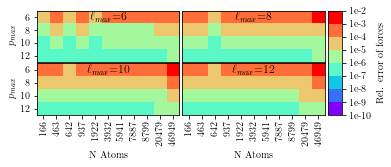

In [76]:
fig = plt.figure(figsize=(4, 1.45))
vmax = -2
vmin = -10

cmap = plt.cm.get_cmap('rainbow', (vmax - vmin))

for i, lmax in enumerate(lmaxs):
    ax = fig.add_subplot(2, 2, 1 + i)
    ax.matshow(np.log10(forces_results[i]), cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title('$\ell_{max}$=' + str(lmax), y=0.70, color='black')
    ax.set_xticks([])
    ax.set_yticks([])
    if i%2 == 0:
        ax.set_ylabel('$p_{max}$')
        ax.set_yticks([0, 1, 2, 3])
        ax.set_yticklabels([str(p) for p in pmaxs])
    if i >= 2:
        ax.set_xticks(range(len(natoms)))
        ax.set_xticklabels([str(n) for n in natoms], rotation='vertical')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('N Atoms')

# create a second axes for the colorbar
ax2 = fig.add_axes([1.01, 0.0, 0.05, 1.0])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, ticks=np.arange(vmin, vmax + 0.1, 1.0),
                               boundaries=np.arange(vmin, vmax + 0.1, 0.5),
                               norm=mpl.colors.Normalize(vmin, vmax),
                               format='1e%i', label='Rel. error of forces')

plt.subplots_adjust(top=1.0, bottom=0.0, left=0.0, right=1.0, wspace=0.02, hspace=0.02)
#ax.set_xlabel('$\ell_{{max}}$')
#ax.set_ylabel('$p_{{max}}$')

#plt.savefig("fmm_vs_fmm_vdw_force.pdf", bbox_inches='tight')
plt.savefig("fmm_vs_fmm_vdw_force.pgf", bbox_inches='tight')
plt.show()
plt.close()

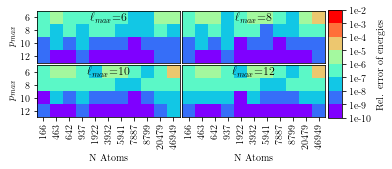

In [152]:
fig = plt.figure(figsize=(4, 1.5))
vmax = -2
vmin = -10

cmap = plt.cm.get_cmap('rainbow', (vmax - vmin))

for i, lmax in enumerate(lmaxs):
    ax = fig.add_subplot(2, 2, 1 + i)
    ax.matshow(np.log10(energies_results[i]), cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title('$\ell_{max}$=' + str(lmax), y=0.70, color='black')
    ax.set_xticks([])
    ax.set_yticks([])
    if i%2 == 0:
        ax.set_ylabel('$p_{max}$')
        ax.set_yticks([0, 1, 2, 3])
        ax.set_yticklabels([str(p) for p in pmaxs])
    if i >= 2:
        ax.set_xticks(range(len(natoms)))
        ax.set_xticklabels([str(n) for n in natoms], rotation='vertical')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('N Atoms')

# create a second axes for the colorbar
ax2 = fig.add_axes([1.01, 0.0, 0.05, 1.0])
cb = mpl.colorbar.ColorbarBase(ax=ax2, cmap=cmap, ticks=np.arange(vmin, vmax + 0.1, 1.0),
                               boundaries=np.arange(vmin, vmax + 0.1, 0.5),
                               norm=mpl.colors.Normalize(vmin, vmax),
                               format='1e%i', label='Rel. error of energies')

plt.subplots_adjust(top=1.0, bottom=0.0, left=0.0, right=1.0, wspace=0.02, hspace=0.02)
#ax.set_xlabel('$\ell_{{max}}$')
#ax.set_ylabel('$p_{{max}}$')

#plt.savefig("fmm_vs_fmm_vdw_esolv.pdf", bbox_inches='tight')
plt.savefig("fmm_vs_fmm_vdw_esolv.pgf", bbox_inches='tight')
plt.show()
plt.close()

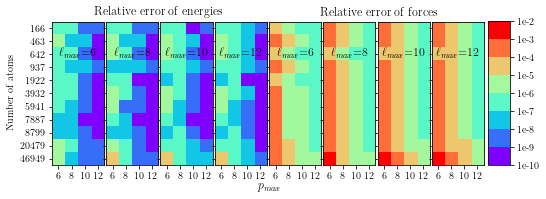

In [154]:
fig, ax = plt.subplots(1, 8, figsize=(6, 2), sharex=True, sharey=True, squeeze=True)
vmax = -2
vmin = -10

cmap = plt.cm.get_cmap('rainbow', (vmax - vmin))
# Plot energies
for i, lmax in enumerate(lmaxs):
    cur_ax = ax[i]
    cur_ax.matshow(np.log10(energies_results[i].T), cmap=cmap, vmin=vmin, vmax=vmax)
    cur_ax.set_title('$\ell_{max}$=' + str(lmax), y=0.72, color='black')
    cur_ax.set_xticks([])
    cur_ax.set_yticks([])
    cur_ax.set_xticks([0, 1, 2, 3])
    cur_ax.set_xticklabels([str(p) for p in pmaxs])
    cur_ax.xaxis.set_ticks_position('bottom')
# Plot forces
for i, lmax in enumerate(lmaxs):
    cur_ax = ax[i+4]
    cur_ax.matshow(np.log10(forces_results[i].T), cmap=cmap, vmin=vmin, vmax=vmax)
    cur_ax.set_title('$\ell_{max}$=' + str(lmax), y=0.72, color='black')
    cur_ax.set_xticks([])
    cur_ax.set_yticks([])
    cur_ax.set_xticks([0, 1, 2, 3])
    cur_ax.set_xticklabels([str(p) for p in pmaxs])
    cur_ax.xaxis.set_ticks_position('bottom')
# Set Y ticks for the most left plot
ax[0].set_yticks(range(len(natoms)))
ax[0].set_yticklabels([str(n) for n in natoms])
ax[0].yaxis.set_ticks_position('left')
ax[0].set_ylabel('Number of atoms')
# Remove empty spaces between plots
plt.subplots_adjust(top=1.0, bottom=0.0, left=0.0, right=1.0, wspace=0.04, hspace=0.04)
# create a second axes for the colorbar
ax2 = fig.add_axes([1.01, 0.0, 0.05, 1.0])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, ticks=np.arange(vmin, vmax + 0.1, 1.0),
                               boundaries=np.arange(vmin, vmax + 0.1, 0.5),
                               norm=mpl.colors.Normalize(vmin, vmax),
                               format='1e%i')#, label='Rel. error of forces')
# Common X label
ax = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_title("$p_{max}$", y=0, pad=-24)

# Commont Titles
ax = fig.add_subplot(121, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_title("Relative error of energies")
ax = fig.add_subplot(122, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_title("Relative error of forces")

#fig.tight_layout()
plt.savefig("fmm_vs_fmm_vdw_v2.pdf", bbox_inches='tight')
#plt.savefig("fmm_vs_fmm_vdw_v2.pgf", bbox_inches='tight')
plt.show()
plt.close()

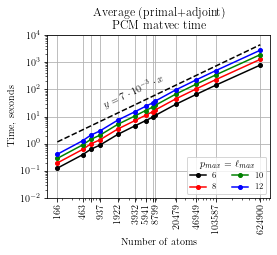

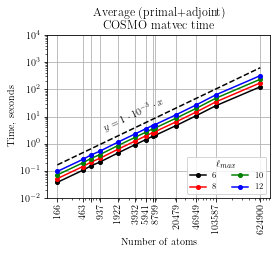

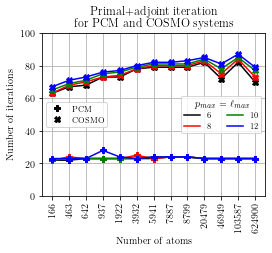

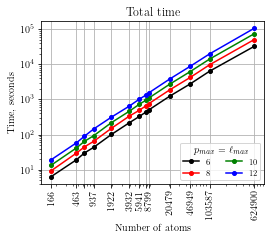

In [19]:
# Average performance of a single matvec for large scale runs with pmax=lmax

# Possible values of lmax
lmaxs = [6, 8, 10, 12]
# Set of styles
styles = {6: {"color": "black"},
          8: {"color": "red"},
          10: {"color": "green"},
          12: {"color": "blue"}}

# List small molecules in a proper order (increasing number of atoms)
small_molecules = ["2rvd_vdw", "2mlt_monomer_vdw", "1ejg_vdw", "2mlt_vdw", "2qho_a_vdw",
                   "2qho_ab_vdw", "2qho_abc_vdw", "2qho_abcd_vdw", "2qho_vdw",
                   "3gdp_vdw", "2gx2_vdw"]
# List big molecules (they are in different directory)
big_molecules = ["3kqz_vdw", "3jb4_vdw"]
# Number of atoms in molecules
natoms = np.array([166, 463, 642, 937, 1922, 3932, 5941, 7887, 8799, 20479, 46949, 103587, 624900])
# Xticks
xticks = [166, 463, 642, 937, 1922, 3932, 5941, 7887, 8799, 20479, 46949, 103587, 624900]
xticklabels = [str(n) for n in [166, 463, "", 937, 1922, 3932, 5941, "", 8799, 20479, 46949, 103587, 624900]]
niter_xticks = range(len(natoms))
niter_xticklables = natoms
#niter_xticklables = [166, 463, 642, 937, "", 3932, "", 7887, "", 11827, "", 23558, "", 117189]
# Prepare plot

fig_pcm, ax_pcm = plt.subplots(figsize=(4, 3))
fig_cosmo, ax_cosmo = plt.subplots(figsize=(4, 3))
fig_niter, ax_niter = plt.subplots(figsize=(4, 3))
fig_time, ax_time = plt.subplots(figsize=(4, 3))

# Generate plots
for lmax in lmaxs:
    pmax = lmax
    pcm_time_per_iter = []
    pcm_niter = []
    cosmo_time_per_iter = []
    cosmo_niter = []
    total_time = []
    # At first read small runs
    for mol in small_molecules:
        # Read file with a given pmax
        fname_fmm = fmm_dir + "/{}.{}.{}.fmm".format(mol, lmax, pmax)
        result_fmm = read_output_file(fname_fmm)
        #time.append(result_fmm["ddpcm step time"]+result_fmm["adjoint ddpcm step time"])
        pcm_time_per_iter.append((result_fmm["ddpcm step time"]+result_fmm["adjoint ddpcm step time"]) /
                                 (result_fmm["ddpcm step niter"]+result_fmm["adjoint ddpcm step niter"]))
        cosmo_time_per_iter.append((result_fmm["ddcosmo step time"]+result_fmm["adjoint ddcosmo step time"]) /
                                 (result_fmm["ddcosmo step niter"]+result_fmm["adjoint ddcosmo step niter"]))
        pcm_niter.append(result_fmm["ddpcm step niter"]+result_fmm["adjoint ddpcm step niter"])
        cosmo_niter.append(result_fmm["ddcosmo step niter"]+result_fmm["adjoint ddcosmo step niter"])
        total_time.append(result_fmm["ddpcm time"])
    # Now read big runs
    for mol in big_molecules:
        # Read file with a given pmax
        fname_fmm = large_dir + "/{}.{}.{}.fmm".format(mol, lmax, pmax)
        result_fmm = read_output_file(fname_fmm)
        pcm_time_per_iter.append((result_fmm["ddpcm step time"]+result_fmm["adjoint ddpcm step time"]) /
                                 (result_fmm["ddpcm step niter"]+result_fmm["adjoint ddpcm step niter"]))
        cosmo_time_per_iter.append((result_fmm["ddcosmo step time"]+result_fmm["adjoint ddcosmo step time"]) /
                                 (result_fmm["ddcosmo step niter"]+result_fmm["adjoint ddcosmo step niter"]))
        pcm_niter.append(result_fmm["ddpcm step niter"]+result_fmm["adjoint ddpcm step niter"])
        cosmo_niter.append(result_fmm["ddcosmo step niter"]+result_fmm["adjoint ddcosmo step niter"])
        total_time.append(result_fmm["ddpcm time"])
    #ax.loglog(natoms, time, label="$p_{{max}}=\ell_{{max}}={}$".format(lmax), markersize=8, marker="s",
    #          linestyle="-", **styles[lmax])
    ax_pcm.loglog(natoms, pcm_time_per_iter, label="{}".format(lmax), linestyle="-",
                  marker="o", markersize=4, **styles[lmax])
    ax_cosmo.loglog(natoms, cosmo_time_per_iter, label="{}".format(lmax), linestyle="-",
                    marker="o", markersize=4, **styles[lmax])
    ax_niter.plot(niter_xticks, pcm_niter, label="PCM", marker="P", linestyle="-", **styles[lmax])
    ax_niter.plot(niter_xticks, cosmo_niter, label="COSMO", marker="X", linestyle="-", **styles[lmax])
    ax_time.loglog(natoms, total_time, label='{}'.format(lmax), marker='o', markersize=4,
                   linestyle="-", **styles[lmax])
# Add guide lines
ax_pcm.loglog(natoms, natoms*7e-3, linestyle="--", color="black")
ax_pcm.text(1000, 20, "$y=7 \cdot 10^{{-3}} \cdot x$", rotation=25)
ax_cosmo.loglog(natoms, natoms*1e-3, linestyle="--", color="black")
ax_cosmo.text(1000, 3, "$y=1 \cdot 10^{{-3}} \cdot x$", rotation=25)

# Append legend data for different pmax
niter_handles1 = []
for lmax in lmaxs:
    # Create a proxy line to add to the legend
    line = Line2D([], [], label="{}".format(lmax), linestyle="-", **styles[lmax])
    niter_handles1.append(line)
line = Line2D([], [], label="PCM", marker="P", color="black", linestyle="")
niter_handles2 = [line]
line = Line2D([], [], label="COSMO", marker="X", color="black", linestyle="")
niter_handles2.append(line)
# Other things
ax_pcm.grid()
ax_cosmo.grid()
ax_niter.grid()
ax_time.grid()

ax_pcm.set_xlabel("Number of atoms")
ax_cosmo.set_xlabel("Number of atoms")
ax_niter.set_xlabel("Number of atoms")
ax_time.set_xlabel("Number of atoms")

ax_pcm.set_ylabel("Time, seconds")
ax_cosmo.set_ylabel("Time, seconds")
ax_niter.set_ylabel("Number of iterations")
ax_time.set_ylabel("Time, seconds")

ax_pcm.set_title("Average (primal+adjoint)\n PCM matvec time")
ax_cosmo.set_title("Average (primal+adjoint)\n COSMO matvec time")
ax_niter.set_title("Primal+adjoint iteration\n for PCM and COSMO systems")
ax_time.set_title("Total time")

ax_pcm.set_xticks(xticks)
ax_cosmo.set_xticks(xticks)
ax_niter.set_xticks(niter_xticks)
ax_time.set_xticks(xticks)

ax_pcm.set_xticklabels(xticklabels, rotation='vertical')
ax_cosmo.set_xticklabels(xticklabels, rotation='vertical')
ax_niter.set_xticklabels(niter_xticklables, rotation='vertical')
ax_time.set_xticklabels(xticklabels, rotation='vertical')

ax_pcm.set_ylim([1e-2, 1e4])
ax_pcm.tick_params(axis="y")
ax_cosmo.set_ylim([1e-2, 1e4])
ax_cosmo.tick_params(axis="y")
ax_niter.tick_params(axis="y")
ax_niter.set_ylim([0, 100])

legend_pcm = ax_pcm.legend(loc="lower right", ncol=2, fontsize=8)
legend_pcm.set_title("$p_{{max}}=\ell_{{max}}$")
legend_cosmo = ax_cosmo.legend(loc="lower right", ncol=2, fontsize=8)
legend_cosmo.set_title("$\ell_{{max}}$")
legend_niter1 = ax_niter.legend(handles=niter_handles1, loc='center right', ncol=2, fontsize=8)
legend_niter1.set_title("$p_{{max}}=\ell_{{max}}$")
legend_niter2 = ax_niter.legend(loc="center left", handles=niter_handles2, fontsize=8)
ax_niter.add_artist(legend_niter1)

legend_time = ax_time.legend(loc="lower right", ncol=2, fontsize=8)
legend_time.set_title("$p_{{max}}=\ell_{{max}}$")

fig_pcm.savefig("fmm_vdw_pcm_iter.pgf", bbox_inches='tight')
fig_cosmo.savefig("fmm_vdw_cosmo_iter.pgf", bbox_inches='tight')
fig_niter.savefig("fmm_vdw_niter.pgf", bbox_inches='tight')
fig_time.savefig("fmm_vdw_time.pgf", bbox_inches='tight')
plt.show()